In [1]:
import sys
import os

if '/root/BBSEA' not in sys.path:
    sys.path.insert(0, '/root/BBSEA')

from utils.visualization import show_box, show_mask, show_points

print(sys.path) 

['/root/BBSEA', '/root/miniconda3/envs/bbsea/lib/python38.zip', '/root/miniconda3/envs/bbsea/lib/python3.8', '/root/miniconda3/envs/bbsea/lib/python3.8/lib-dynload', '', '/root/miniconda3/envs/bbsea/lib/python3.8/site-packages']


In [10]:
import torch
from torchvision.io import read_image
from torchvision.transforms import Resize
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from ultralytics import YOLO
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import clip
from PIL import Image

from utils.visualization import show_box, show_mask, show_points
from config.core import device, SAM_model_path, YOLOv8_model_path

In [3]:
class YOLOv8:
    def __init__(self, model):
        self.model=YOLO(model).to(device)
        self.cls_name_map=self.model.names

    def detect(self, image, visualize=False):
        """
        return dict(bbox : name)
        """
        results=self.model(image, verbose=True)

        # Assuming only one image is input, 
        # so the results index is fixed to be zero.
        boxes=results[0].boxes
        xyxys=boxes.xyxy
        cls_name=[self.cls_name_map[int(i.item())] for i in boxes.cls]
        # box_cls_map={tuple(k.cpu().tolist()):j for k,j in zip(xyxys, cls_name)}

        if visualize:
            plt.figure(figsize=(10, 10))
            plt.imshow(image) 
            ax = plt.gca()  
            for i in range(len(xyxys)):
                xyxy = xyxys[i].cpu().numpy() 
                name = cls_name[i]
                show_box(xyxy, ax, name)
            plt.axis('off')
            plt.savefig("detect_segment_yolov8.png")
            plt.close()
        
        return xyxys, cls_name


class SAM:
    def __init__(self, model_type, checkpoint):
        self.model_type=model_type
        self.sam = sam_model_registry[self.model_type](checkpoint)
        self.sam.to(device)
        self.predictor = SamPredictor(self.sam)
        # Ensure the longest side length of the image is 1024
        self.transform = ResizeLongestSide(self.sam.image_encoder.img_size)
    
    def segment_bbox(self, image, bboxes, visualization=False):
        transformed_boxes = self.predictor.transform.apply_boxes_torch(bboxes, image.shape[:2])
        self.predictor.set_image(image)
        masks, _, _ =  self.predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )

        if visualization:
            plt.figure(figsize=(10, 10))
            plt.imshow(image)
            for mask in masks:
                show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
            for box in bboxes:
                show_box(box.cpu().numpy(), plt.gca())
            plt.axis('off')
            plt.savefig("detect_segment_sam.png")
            plt.close()
        
        return masks

In [4]:
detector=YOLOv8(YOLOv8_model_path["yolov8n"])
segmentor=SAM("vit_h", SAM_model_path["vit_h"])

image_path="/root/BBSEA/images/lovers_rgb.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

xyxys, cls_name = detector.detect(image, visualize=True)
print("the detected bboxes are:")
box_cls_map={tuple(k.cpu().tolist()):j for k,j in zip(xyxys, cls_name)}
for i in box_cls_map:
    print(f"{i}:{box_cls_map[i]}")

masks=segmentor.segment_bbox(image, xyxys, visualization=True)
masks, cls_name


0: 416x640 5 persons, 150.2ms
Speed: 5.3ms preprocess, 150.2ms inference, 540.5ms postprocess per image at shape (1, 3, 416, 640)
the detected bboxes are:
(284.61785888671875, 100.96958923339844, 338.1485290527344, 217.51695251464844):person
(36.76882553100586, 92.6554183959961, 95.83953857421875, 217.47032165527344):person
(92.6596450805664, 1.4298522472381592, 281.4833068847656, 216.26303100585938):person
(151.58924865722656, 35.57954025268555, 281.7635192871094, 215.9183349609375):person
(93.26045227050781, 4.2045159339904785, 205.5601806640625, 217.07864379882812):person


(tensor([[[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False]]],
 
 
         [[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False]]],
 
 
         [[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False,

In [57]:
mask=masks[4]
mask = mask.squeeze().cpu().numpy()
mask.shape

(219, 341)

In [58]:
rows = np.any(mask, axis=1)
cols = np.any(mask, axis=0)
rows.shape

(219,)

In [59]:
ymin, ymax = np.where(rows)[0][0], np.where(rows)[0][-1]
xmin, xmax = np.where(cols)[0][0], np.where(cols)[0][-1]

In [60]:
image=Image.open("/root/BBSEA/images/lovers_rgb.png")
# image_np = np.array(image)
# image_np.shape

In [61]:
cropped_image = image.crop((xmin, ymin, xmax, ymax))
cropped_image.size

(110, 213)

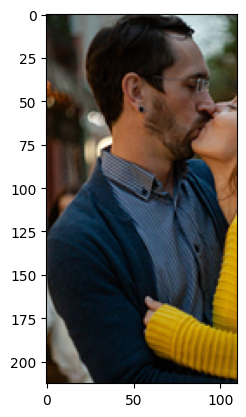

In [62]:
plt.imshow(cropped_image)

In [71]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [67]:
image = preprocess(cropped_image).unsqueeze(0).to(device)
cls_name=["drawer", "bin", "block", "stick", "man", "woman"]
text = clip.tokenize(cls_name).to(device)

In [70]:
with torch.no_grad():
    # image_features = model.encode_image(image)
    # text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]
print(cls_name[probs.argmax()])

Label probs: [[   0.032776     0.11267    0.073853     0.17725     0.34155     0.26196]]
man


4